In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Data Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),

    # Lighting / color variations
    transforms.ColorJitter(
        brightness=0.25,
        contrast=0.25,
        saturation=0.2,
        hue=0.02
    ),

    transforms.ToTensor(),

    # Normalization
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),

    # Prevent overfitting + good for imbalance
    transforms.RandomErasing(p=0.3)
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
seed_list = [10, 21, 32, 42, 70, 99]

best_overall_acc = 0.0
best_overall_wts = None
best_seed = None

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Food_dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Food_dataset/val', transform=val_transforms)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path='/content/drive/MyDrive/mobilenetv2_food_spoilage_new.pth'

In [ ]:
for seed in seed_list:
    print(f"\n _______________")
    print(f"Training with SEED = {seed}")

    set_seed(seed)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Reinitialize model, optimizer, and weights every run
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    # Replace the classifier for 2 classes
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, 2)
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-4)

    # Training variables
    num_epochs = 15
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Training Loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}\n------------")

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_acc = running_corrects.double() / len(train_dataset)

        # Validation
        model.eval()
        val_corrects = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_dataset)

        print(f"Train Acc: {train_acc:.4f}  |  Val Acc: {val_acc:.4f}")

        # Save best model for this seed
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())


    print(f" Best Val Accuracy for seed {seed}: {best_acc:.4f}")

    # Compare Across Seeds

    if best_acc > best_overall_acc:
        best_overall_acc = best_acc
        best_overall_wts = best_model_wts
        best_seed = seed



 _______________
Training with SEED = 10
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 153MB/s]


Epoch 1/15
------------
Train Acc: 0.7759  |  Val Acc: 0.7955
Epoch 2/15
------------
Train Acc: 0.8879  |  Val Acc: 0.8409
Epoch 3/15
------------
Train Acc: 0.9397  |  Val Acc: 0.8295
Epoch 4/15
------------
Train Acc: 0.9511  |  Val Acc: 0.8636
Epoch 5/15
------------
Train Acc: 0.9684  |  Val Acc: 0.8636
Epoch 6/15
------------
Train Acc: 0.9655  |  Val Acc: 0.9205
Epoch 7/15
------------
Train Acc: 0.9713  |  Val Acc: 0.9091
Epoch 8/15
------------
Train Acc: 0.9770  |  Val Acc: 0.9091
Epoch 9/15
------------
Train Acc: 0.9799  |  Val Acc: 0.8750
Epoch 10/15
------------
Train Acc: 0.9828  |  Val Acc: 0.8977
Epoch 11/15
------------
Train Acc: 0.9770  |  Val Acc: 0.8864
Epoch 12/15
------------
Train Acc: 0.9770  |  Val Acc: 0.8750
Epoch 13/15
------------
Train Acc: 0.9856  |  Val Acc: 0.8977
Epoch 14/15
------------
Train Acc: 0.9770  |  Val Acc: 0.9205
Epoch 15/15
------------
Train Acc: 0.9741  |  Val Acc: 0.8977
 Best Val Accuracy for seed 10: 0.9205

 _______________
Trainin

In [ ]:
save_path = f"/content/drive/MyDrive/mobilenetv2_food_spoilage_best_seed_{best_seed}.pth"
torch.save(best_overall_wts, save_path)

print(f" Best Seed Overall: {best_seed}")
print(f" Best Accuracy: {best_overall_acc:.4f}")
print(f" Model saved as: {save_path}")

 Best Seed Overall: 21
 Best Accuracy: 0.9545
 Model saved as: /content/drive/MyDrive/mobilenetv2_food_spoilage_best_seed_21.pth


In [ ]:
all_preds = []
all_labels = []
val_losses = []

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/mobilenetv2_food_spoilage_best_seed_21.pth", map_location=device))
model = model.to(device)
model.eval()

In [ ]:
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_losses.append(loss.item())
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# 5. Classification Report
target_names = val_dataset.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

 not_spoiled       0.96      0.96      0.96        47
     spoiled       0.95      0.95      0.95        41

    accuracy                           0.95        88
   macro avg       0.95      0.95      0.95        88
weighted avg       0.95      0.95      0.95        88



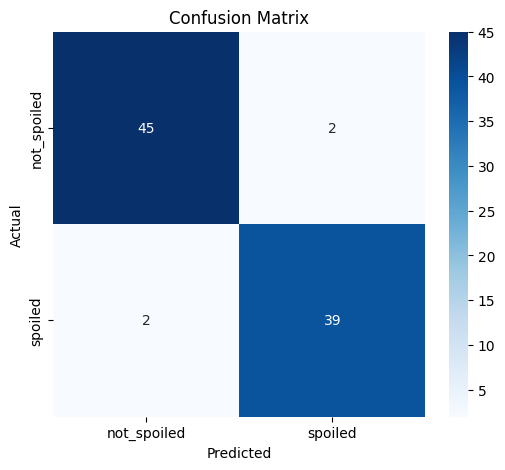

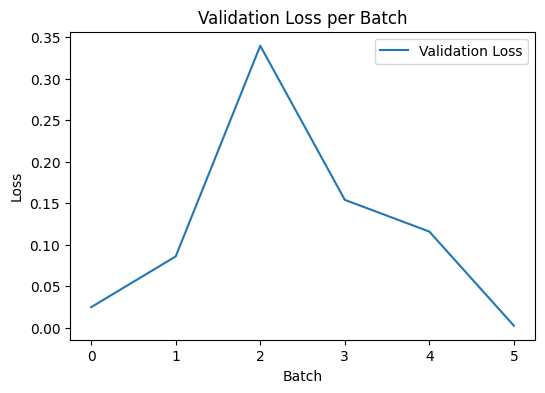

In [ ]:
# 6. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 7. Loss Plot
plt.figure(figsize=(6,4))
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss per Batch')
plt.legend()
plt.show()

In [ ]:
val_dataset.classes

['not_spoiled', 'spoiled']

In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights=None)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)
model = model.to(device)

model.load_state_dict(torch.load("/content/drive/MyDrive/mobilenetv2_food_spoilage_best_seed_21.pth", map_location=device))

model = model.to(device)
model.eval()
print("Model Loaded Successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded Successfully!


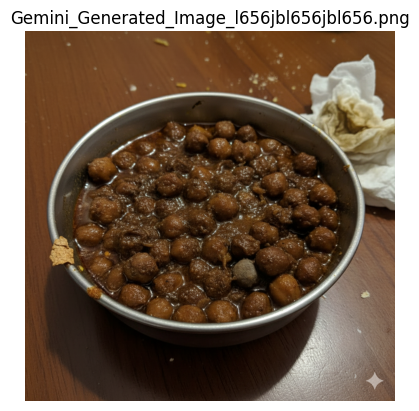

Image: Gemini_Generated_Image_l656jbl656jbl656.png → Predicted Class: spoiled


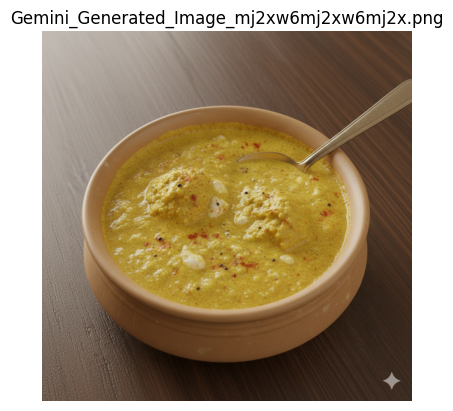

Image: Gemini_Generated_Image_mj2xw6mj2xw6mj2x.png → Predicted Class: not_spoiled


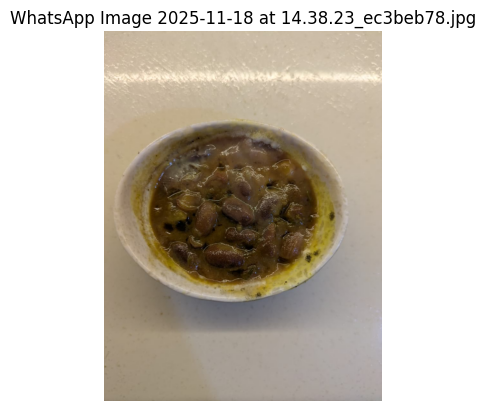

Image: WhatsApp Image 2025-11-18 at 14.38.23_ec3beb78.jpg → Predicted Class: spoiled


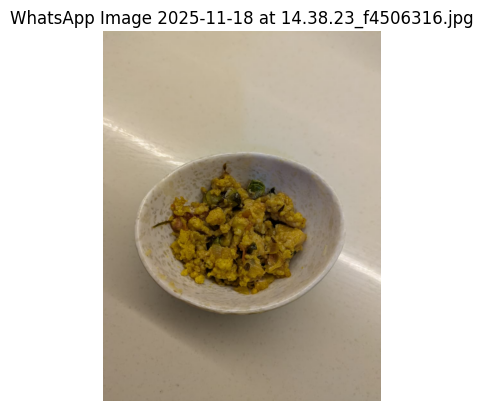

Image: WhatsApp Image 2025-11-18 at 14.38.23_f4506316.jpg → Predicted Class: spoiled


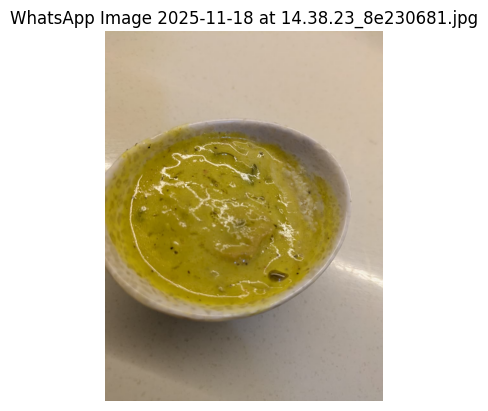

Image: WhatsApp Image 2025-11-18 at 14.38.23_8e230681.jpg → Predicted Class: spoiled


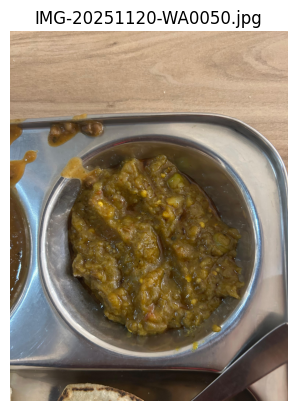

Image: IMG-20251120-WA0050.jpg → Predicted Class: spoiled


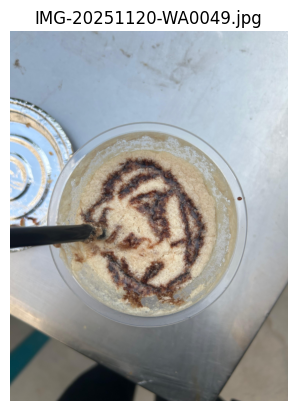

Image: IMG-20251120-WA0049.jpg → Predicted Class: spoiled


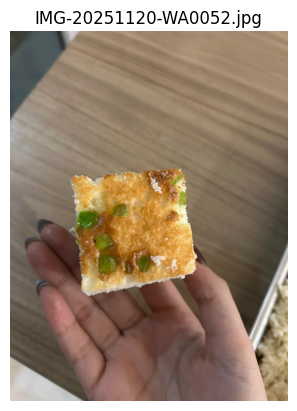

Image: IMG-20251120-WA0052.jpg → Predicted Class: not_spoiled


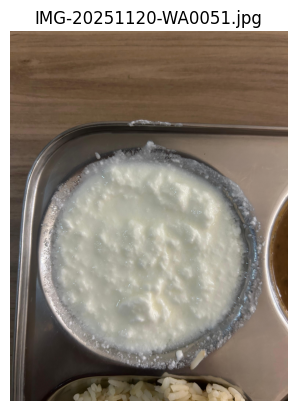

Image: IMG-20251120-WA0051.jpg → Predicted Class: spoiled


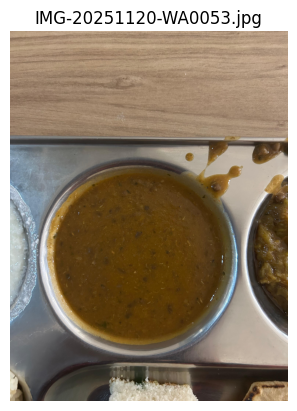

Image: IMG-20251120-WA0053.jpg → Predicted Class: not_spoiled


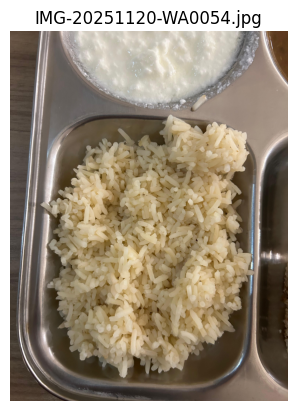

Image: IMG-20251120-WA0054.jpg → Predicted Class: not_spoiled


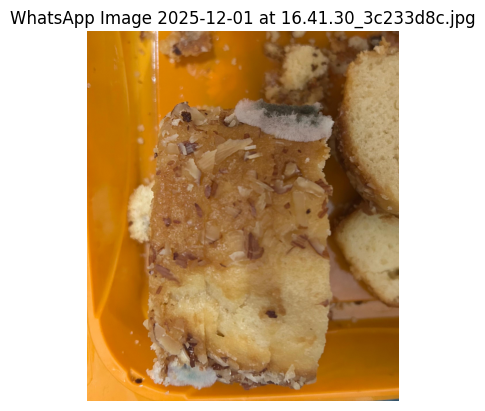

Image: WhatsApp Image 2025-12-01 at 16.41.30_3c233d8c.jpg → Predicted Class: not_spoiled


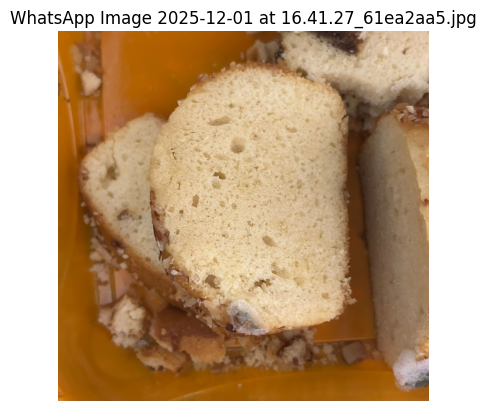

Image: WhatsApp Image 2025-12-01 at 16.41.27_61ea2aa5.jpg → Predicted Class: spoiled


In [5]:
import os

folder_path = "/content/drive/MyDrive/Food_dataset/test"
class_names = ['not_spoiled', 'spoiled'] # update based on your classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)


    if not file_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img = Image.open(file_path).convert("RGB")


    plt.imshow(img)
    plt.title(file_name)
    plt.axis("off")
    plt.show()


    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        predicted_class_idx = torch.argmax(outputs, dim=1).item()

    print(f"Image: {file_name} → Predicted Class: {class_names[predicted_class_idx]}")

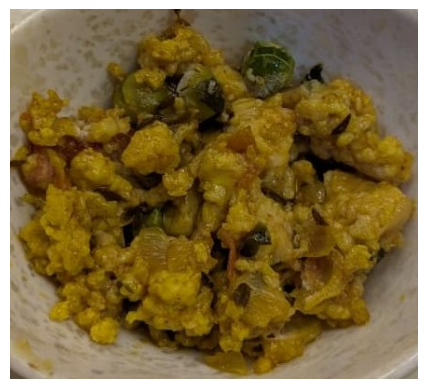

Predicted class: 1


In [ ]:
from PIL import Image
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

img = Image.open("/content/copy8.jpg").convert("RGB")

import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')   # remove axis
plt.show()

img = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img)
    predicted_class = torch.argmax(outputs, dim=1)

print("Predicted class:", predicted_class.item())